In [1]:
import numpy as onp
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax_cosmo as jc

import cloudpickle as pickle


def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

def reshape_data(dat):
    realpart = dat[:, ::2, :, :]
    impart = dat[:, 1::2, :, :]

    return jnp.stack([realpart, impart], axis=-1)

In [2]:
5000 / 5

1000.0

In [3]:
jax.config.update("jax_enable_x64", False)

In [4]:
### ------------- IMNN PARAMETERS -------------
θ_fid = jnp.array([0.3, 0.800]) # CHANGE TO OmegaM=0.6
δθ = jnp.array([0.0115, 0.015])

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))

n_summaries = 2

n_s = 1000
n_d = 250

n_params = 2
n_summaries = n_params
print(θ_der)

[[0.29425 0.8    ]
 [0.3     0.7925 ]
 [0.30575 0.8    ]
 [0.3     0.8075 ]]


In [5]:
# first load all data
np = onp

datadir = "/data101/makinen/borg_sunglass/"

import sys,os

folders = ["omegaM", "sigma8", "fiducial", "prior"]
#folders = ["prior"]


def get_fiducial(
                 sim_path = "/data101/makinen/borg_sunglass/fiducial/",
                 data_folder = "/Cls/",
                 num_sims=1000):

    sim_path = sim_path + data_folder

    dir_list = os.listdir(sim_path)
    
    sim_index = []
    sims = []
    
    for filename in dir_list:
        #print(filename)
        sim = np.load(sim_path + filename)
        sims.append(sim)
    
    return np.array(sims)[:num_sims]


In [6]:
θ_fid, δθ

(Array([0.3, 0.8], dtype=float32), Array([0.0115, 0.015 ], dtype=float32))

In [7]:
def get_all_derivatives(num_sims, 
                        n_params=2, 
                        sim_path = "/data101/makinen/borg_sunglass/",
                        data_folder = "/Cls/",
                        params=["omegaM", "sigma8"],
                        θ_fid=θ_fid,
                        δθ=δθ):
    n_params = len(params)
    derivative_sims = [] #[[]]*n_params
    
    derivative_param_values = [] # [[]]*n_params

    # go through each seed index
    for i in range(num_sims):
        # go through each parameter
        for j,p in enumerate(params):
            
            try:
                sim_folder = sim_path + p + data_folder
                #print(sim_folder)

                # try loading plus and minus sims
                minus_value = θ_fid[j] - δθ[j]
                if p == "sigma8":
                    filename = sim_folder + "sim_%.3f_%d.npy"%(minus_value, i)
                else:
                    filename = sim_folder + "sim_%.4f_%d.npy"%(minus_value, i)
                    
                #print(filename)
                minus_sim = np.load(filename)
                
                plus_value = θ_fid[j] + δθ[j]
                if p == "sigma8":
                    filename = sim_folder + "sim_%.3f_%d.npy"%(plus_value, i)
                else:
                    filename = sim_folder + "sim_%.4f_%d.npy"%(plus_value, i)
                plus_sim = np.load(filename)
                #print(filename)
                
                derivative_sims.append(minus_sim)
                derivative_sims.append(plus_sim)
                
                derivative_param_values.append(minus_value)
                derivative_param_values.append(plus_value)
                
            except:
                print("missed folder", filename)
                print("missed idx", i)
                pass
            
    derivative_sims = np.array(derivative_sims)
    
    print("collected derivative sims: ", derivative_sims.shape)
    
    outs = np.zeros((len(derivative_sims),) + derivative_sims.shape[1:])
    #print(outs.shape)
    
    outs[0::4, ...] = derivative_sims[0::4, ...]
    outs[1::4, ...] = derivative_sims[2::4, ...]
    outs[2::4, ...] = derivative_sims[1::4, ...]
    outs[3::4, ...] = derivative_sims[3::4, ...]
    
    print("output: ", outs.shape)
    
    # stack them -,-,+,+,...
    #for j in range(n_params):
       # for q in range(2):
    
       # outs[j*::2*n_params, ...] = derivative_sims[j][::2, ...] # minus sims per param
       # outs[j+1::2*n_params, ...] = derivative_sims[j][1::2, ...] # plus sims per param
        
    return outs #, np.array(derivative_param_values)
    
    

In [8]:
125*4

500

In [9]:
dervs = get_all_derivatives(num_sims=125)

collected derivative sims:  (500, 64, 2)
output:  (500, 64, 2)


In [10]:
dervs.shape

(500, 64, 2)

In [11]:
248 / 4

62.0

In [12]:
n_d = 200
n_s = 1988 // 2 #1976 // 2

CL_NOISE = 0.0

dervs = get_all_derivatives(num_sims=n_d*2)[:, :, 1] # first idx is the ells
full_fid = get_fiducial(num_sims=n_s*2)[:, :, 1]

#np.random.shuffle(full_fid)

dervs *= 1e7
full_fid *= 1e7

#dervs = np.arcsinh(dervs + 5.0) + onp.random.normal(size=dervs.shape)*CL_NOISE
#full_fid = np.arcsinh(full_fid + 5.0) + onp.random.normal(size=full_fid.shape)*CL_NOISE

# dervs = jnp.arcsinh(dervs)
# fid = jnp.arcsinh(fid)


val_dervs = dervs[n_d*4:, :]
dervs = dervs[:n_d*4, :]

val_fid = full_fid[n_s:, :]
fid = full_fid[:n_s, :]

val_dervs.shape, dervs.shape, fid.shape, val_fid.shape

collected derivative sims:  (1600, 64, 2)
output:  (1600, 64, 2)


((800, 64), (800, 64), (994, 64), (994, 64))

In [13]:
dervs.shape

(800, 64)

In [14]:
np.max(fid)

1.515809403894216

Text(0.5, 1.0, 'sigma8 +')

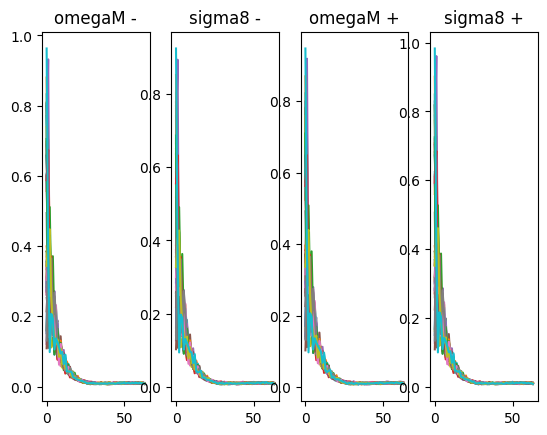

In [15]:
plt.subplot(141)
for d in dervs[0::16]:
    plt.plot(d, label='Om -')
    
plt.title("omegaM -")

plt.subplot(142)
for d in dervs[1::16]:
    plt.plot(d, label='Om -')
    
plt.title("sigma8 -")

plt.subplot(143)
for d in dervs[2::16]:
    plt.plot(d, label='Om -')
    
plt.title("omegaM +")


plt.subplot(144)
for d in dervs[3::16]:
    plt.plot(d, label='s8 -')
    
plt.title("sigma8 +")

Text(0.5, 1.0, 'variance in fid dataset')

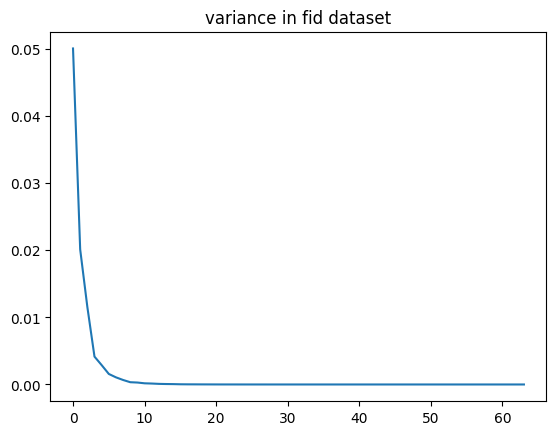

In [16]:
plt.plot(np.var(full_fid[:, :], axis=0))
#plt.plot(np.var(val_fid[:, :], axis=0))
plt.title("variance in fid dataset")

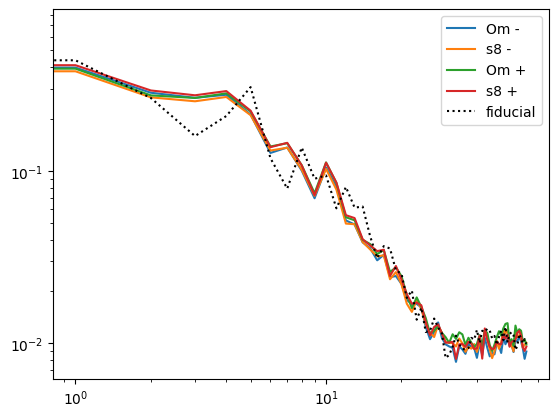

In [17]:
plt.plot(dervs[0], label='Om -')
plt.plot(dervs[1], label='s8 -')

plt.plot(dervs[2], label='Om +')

plt.plot(dervs[3], label='s8 +')

plt.plot(fid[0], c='k', ls=':', label='fiducial')

#plt.plot(Cls_prior[:, 1], c='green', ls='-', label='s8=1.3967')

plt.loglog()
plt.legend()

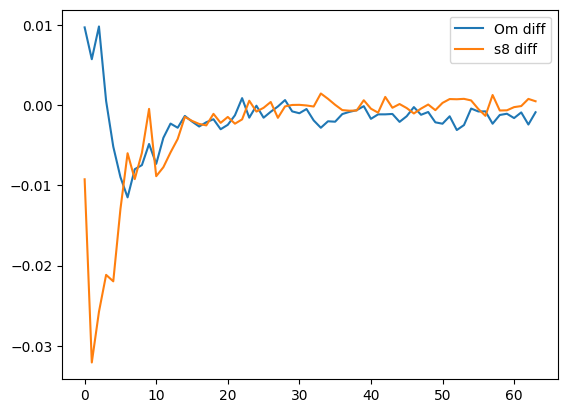

In [18]:
plt.plot(dervs[0] - dervs[2], label='Om diff')
plt.plot(dervs[1] - dervs[3], label='s8 diff')



#plt.plot(fid[0], c='k', ls=':', label='fiducial')

#plt.plot(Cls_prior[:, 1], c='green', ls='-', label='s8=1.3967')

#plt.loglog()
plt.legend()

In [19]:
# now set up an IMNN MLP network

from typing import Sequence, Any
Array = Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn

class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.swish(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

In [20]:
key = jax.random.PRNGKey(0)

n_params = 2
n_outputs = n_params
#n_d = 250

input_shape = (64,)

model = MLP([128,128,128,n_outputs])

w = model.init(key, jnp.ones((64)))

outs = model.apply(w, jnp.ones((64)))

In [21]:
outs

Array([-0.06432068, -0.12648383], dtype=float32)

In [22]:
cd /home/makinen/repositories/alfi_lensing/imnn_scripts/

/home/makinen/repositories/alfi_lensing/imnn_scripts


In [23]:
from nets import *
from imnn_mod import *

2023-10-13 10:54:41.986236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [24]:
#### ------------- SET UP IMNN -------------

optimiser = optax.adam(learning_rate=1e-4)

model_key = jax.random.PRNGKey(42)
rng, key = jax.random.split(key)

In [25]:
%xmode context

Exception reporting mode: Context


In [26]:
from imnn.experimental import NumericalGradientIMNN
import gc

In [27]:
from jax import config
config.update("jax_debug_nans", True)

In [28]:
δθ # this is the distance between fiducial and the +/- sims
# 2 * δθ is the distance between + and - sims. need this for IMNN.

Array([0.0115, 0.015 ], dtype=float32)

In [29]:
idx = 4
num_bins = 64-idx
input_shape = (64 - idx,)

In [30]:
IMNN = NumericalGradientIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
    input_shape=input_shape, θ_fid=θ_fid, δθ=2*δθ, model=model,
    optimiser=optimiser, key_or_state=jnp.array(model_key),
    fiducial=jnp.log(fid[..., idx:]), 
    derivative=jnp.log(dervs[..., idx:].reshape(n_d, 2, n_params, num_bins)),
    validation_fiducial=jnp.log(val_fid[..., idx:]),
    validation_derivative=jnp.log(val_dervs[..., idx:].reshape(n_d, 2, n_params, num_bins)),
    dummy_graph_input=None,  # dummy graph input
    no_invC=False,
    do_reg=True,
    evidence=False)

In [31]:
IMNN.set_F_statistics(IMNN.w, model_key)

In [32]:
IMNN.F

Array([[1740.6139 ,  748.96094],
       [ 748.961  ,  418.19028]], dtype=float32)

In [40]:
## ------------- TRAIN THE IMNN -------------
np=jnp

gc.collect()
key,rng = jax.random.split(key)

IMNN.fit(10.0, 0.0000001, γ=1.0, rng=jnp.array(rng), patience=1000, min_iterations=300)

In [41]:
IMNN.F, IMNN.C

(Array([[21233.393 ,  2762.8047],
        [ 2762.805 ,  4068.3545]], dtype=float32),
 Array([[1.0484235 , 0.00891882],
        [0.00891882, 1.0638216 ]], dtype=float32))

[<AxesSubplot: ylabel='$|{\\bf F}|$'>,
 <AxesSubplot: ylabel='$|{\\bf C}|$ and $|{\\bf C}^{-1}|$'>,
 <AxesSubplot: xlabel='Number of iterations', ylabel='$\\Lambda_2$'>,
 <AxesSubplot: ylabel='$r$'>]

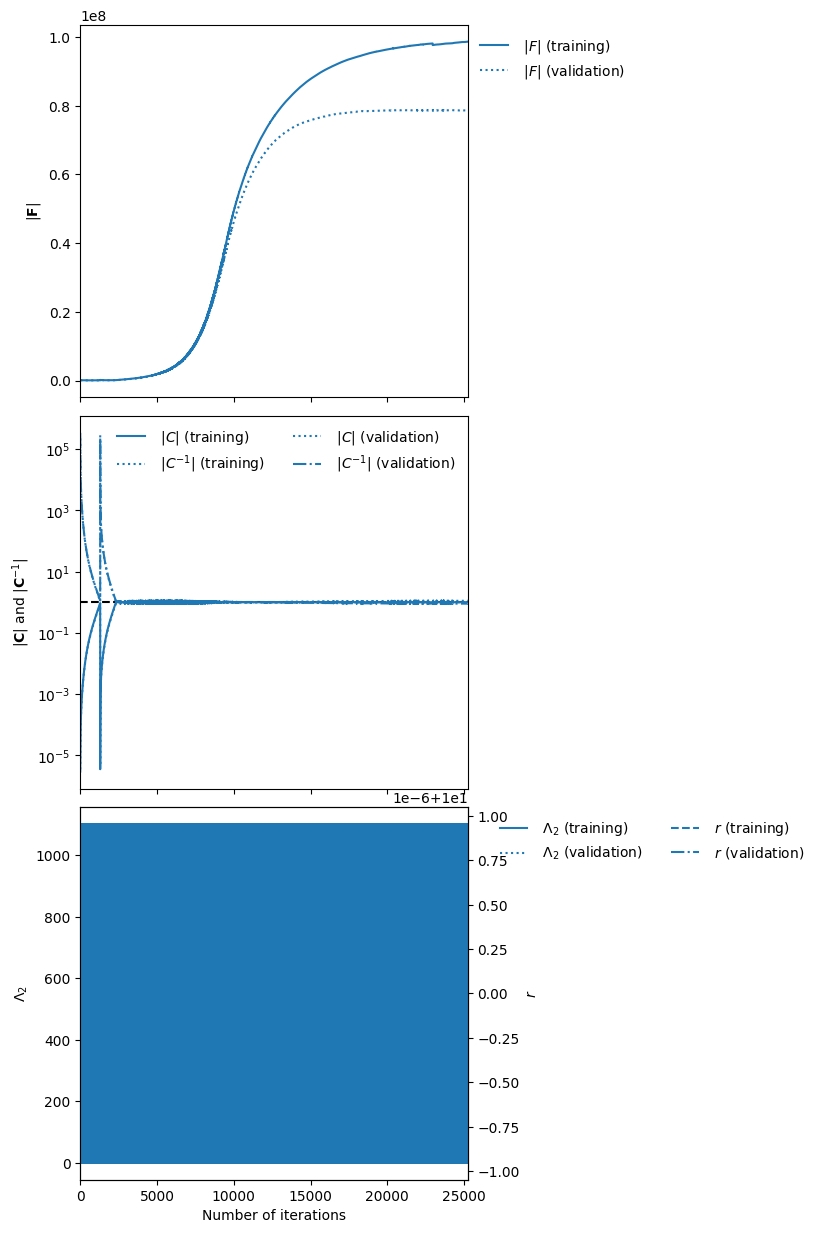

In [42]:
IMNN.plot()

In [1]:
F_moped = np.array([[21933.05318631,  4449.15538056],
       [ 4449.15538056, 28624.43633167]]) 

F_imnn_old = np.array([[20413.395 ,  4184.5166],
        [ 4184.517 , 21088.354 ]])

F_moped_new = np.array([[22045.73252133,  2843.51237204],
       [ 2843.51237204,  4453.72930052]])

NameError: name 'np' is not defined

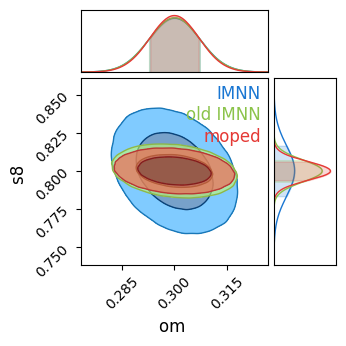

In [45]:
from chainconsumer import ChainConsumer

parameters = ['om', 's8']

Cplot = np.array(np.linalg.inv(IMNN.F))

cs = ChainConsumer()
cs.add_covariance(mean=onp.array(θ_fid), covariance = Cplot, parameters=parameters, name="IMNN")
cs.add_covariance(mean=onp.array(θ_fid), covariance = np.linalg.inv(F_imnn_old), parameters=parameters, name="old IMNN")
cs.add_covariance(mean=onp.array(θ_fid), covariance = np.linalg.inv(F_moped), parameters=parameters, name="moped")

#cs.configure(usetex=False, serif=False)
cs.plotter.plot()
plt.show()

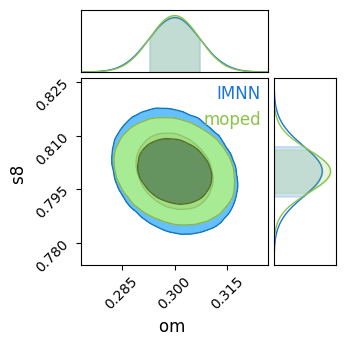

In [37]:
from chainconsumer import ChainConsumer

parameters = ['om', 's8']

Cplot = np.array(np.linalg.inv(IMNN.F))

cs = ChainConsumer()
cs.add_covariance(mean=onp.array(θ_fid), covariance = Cplot, parameters=parameters, name="IMNN")
cs.add_covariance(mean=onp.array(θ_fid), covariance = np.linalg.inv(F_moped), parameters=parameters, name="moped")

#cs.configure(usetex=False, serif=False)
cs.plotter.plot()
plt.show()

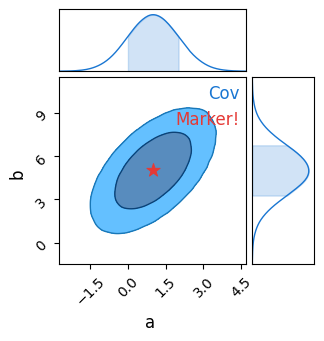

In [40]:
mean = [1, 5]
cov = [[1, 1], [1, 3]]
parameters = ["a", "b"]

c = ChainConsumer()
c.add_covariance(mean, cov, parameters=parameters, name="Cov")
c.add_marker(mean, parameters=parameters, name="Marker!", marker_style="*", marker_size=100, color="r")
c.configure(usetex=False, serif=False)
fig = c.plotter.plot()